In [59]:
%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from bitsandbobs.plt import set_size
import matplotlib as mpl

# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("/path/to/repo/experiment_analysis/dat/")
data_dir = "../../../paper_code/experiment_analysis/data/"
os.makedirs("../img/", exist_ok=True)


2024-07-11 15:28:36,101 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [15]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df = utl.add_structure_and_hierarchy_scores(meta_df)
# Only compare natural movie one more repeats blocks 3.0 and 8.0 and spontaneous activity (block 'null')
meta_df = meta_df.query("block in ['merged_3.0_and_8.0', 'null']")

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
len_before = len(meta_df)
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("tau_R > 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-07-11 12:33:22,714 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-07-11 12:33:22,716 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-07-11 12:33:33,294 | INFO     | notebook | <module> | removed 871 rows due to unexpected timescales


2024-07-11 15:28:39,717 | INFO     | plot_helper | panel_stimulus_violins | dropped 0 rows with nan / inf
2024-07-11 15:28:40,629 | INFO     | plot_helper | panel_stimulus_violins | violins for tau_double, ['natural_movie_one_more_repeats' 'spontaneous'], N=951
2024-07-11 15:28:40,633 | INFO     | plot_helper | panel_stimulus_violins | median [natural_movie_one_more_repeats]: 295.092, [spontaneous]: 347.154
2024-07-11 15:28:40,633 | INFO     | plot_helper | panel_stimulus_violins | natural_movie_one_more_repeats vs spontaneous pairwise_diff=1.1% diff_of_medians=17.6% p=0.04693915563608012
2024-07-11 15:28:40,930 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats median: 2.4700 quantiles: [2.44393725 2.52444581] from 500 samples of length 951
2024-07-11 15:28:40,930 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats min: 0.95 max: 3.9
2024-07-11 15:28:41,167 | DEBUG    | plot_helper | fancy_violins | spontaneous median: 2.5431 quantiles: [2.

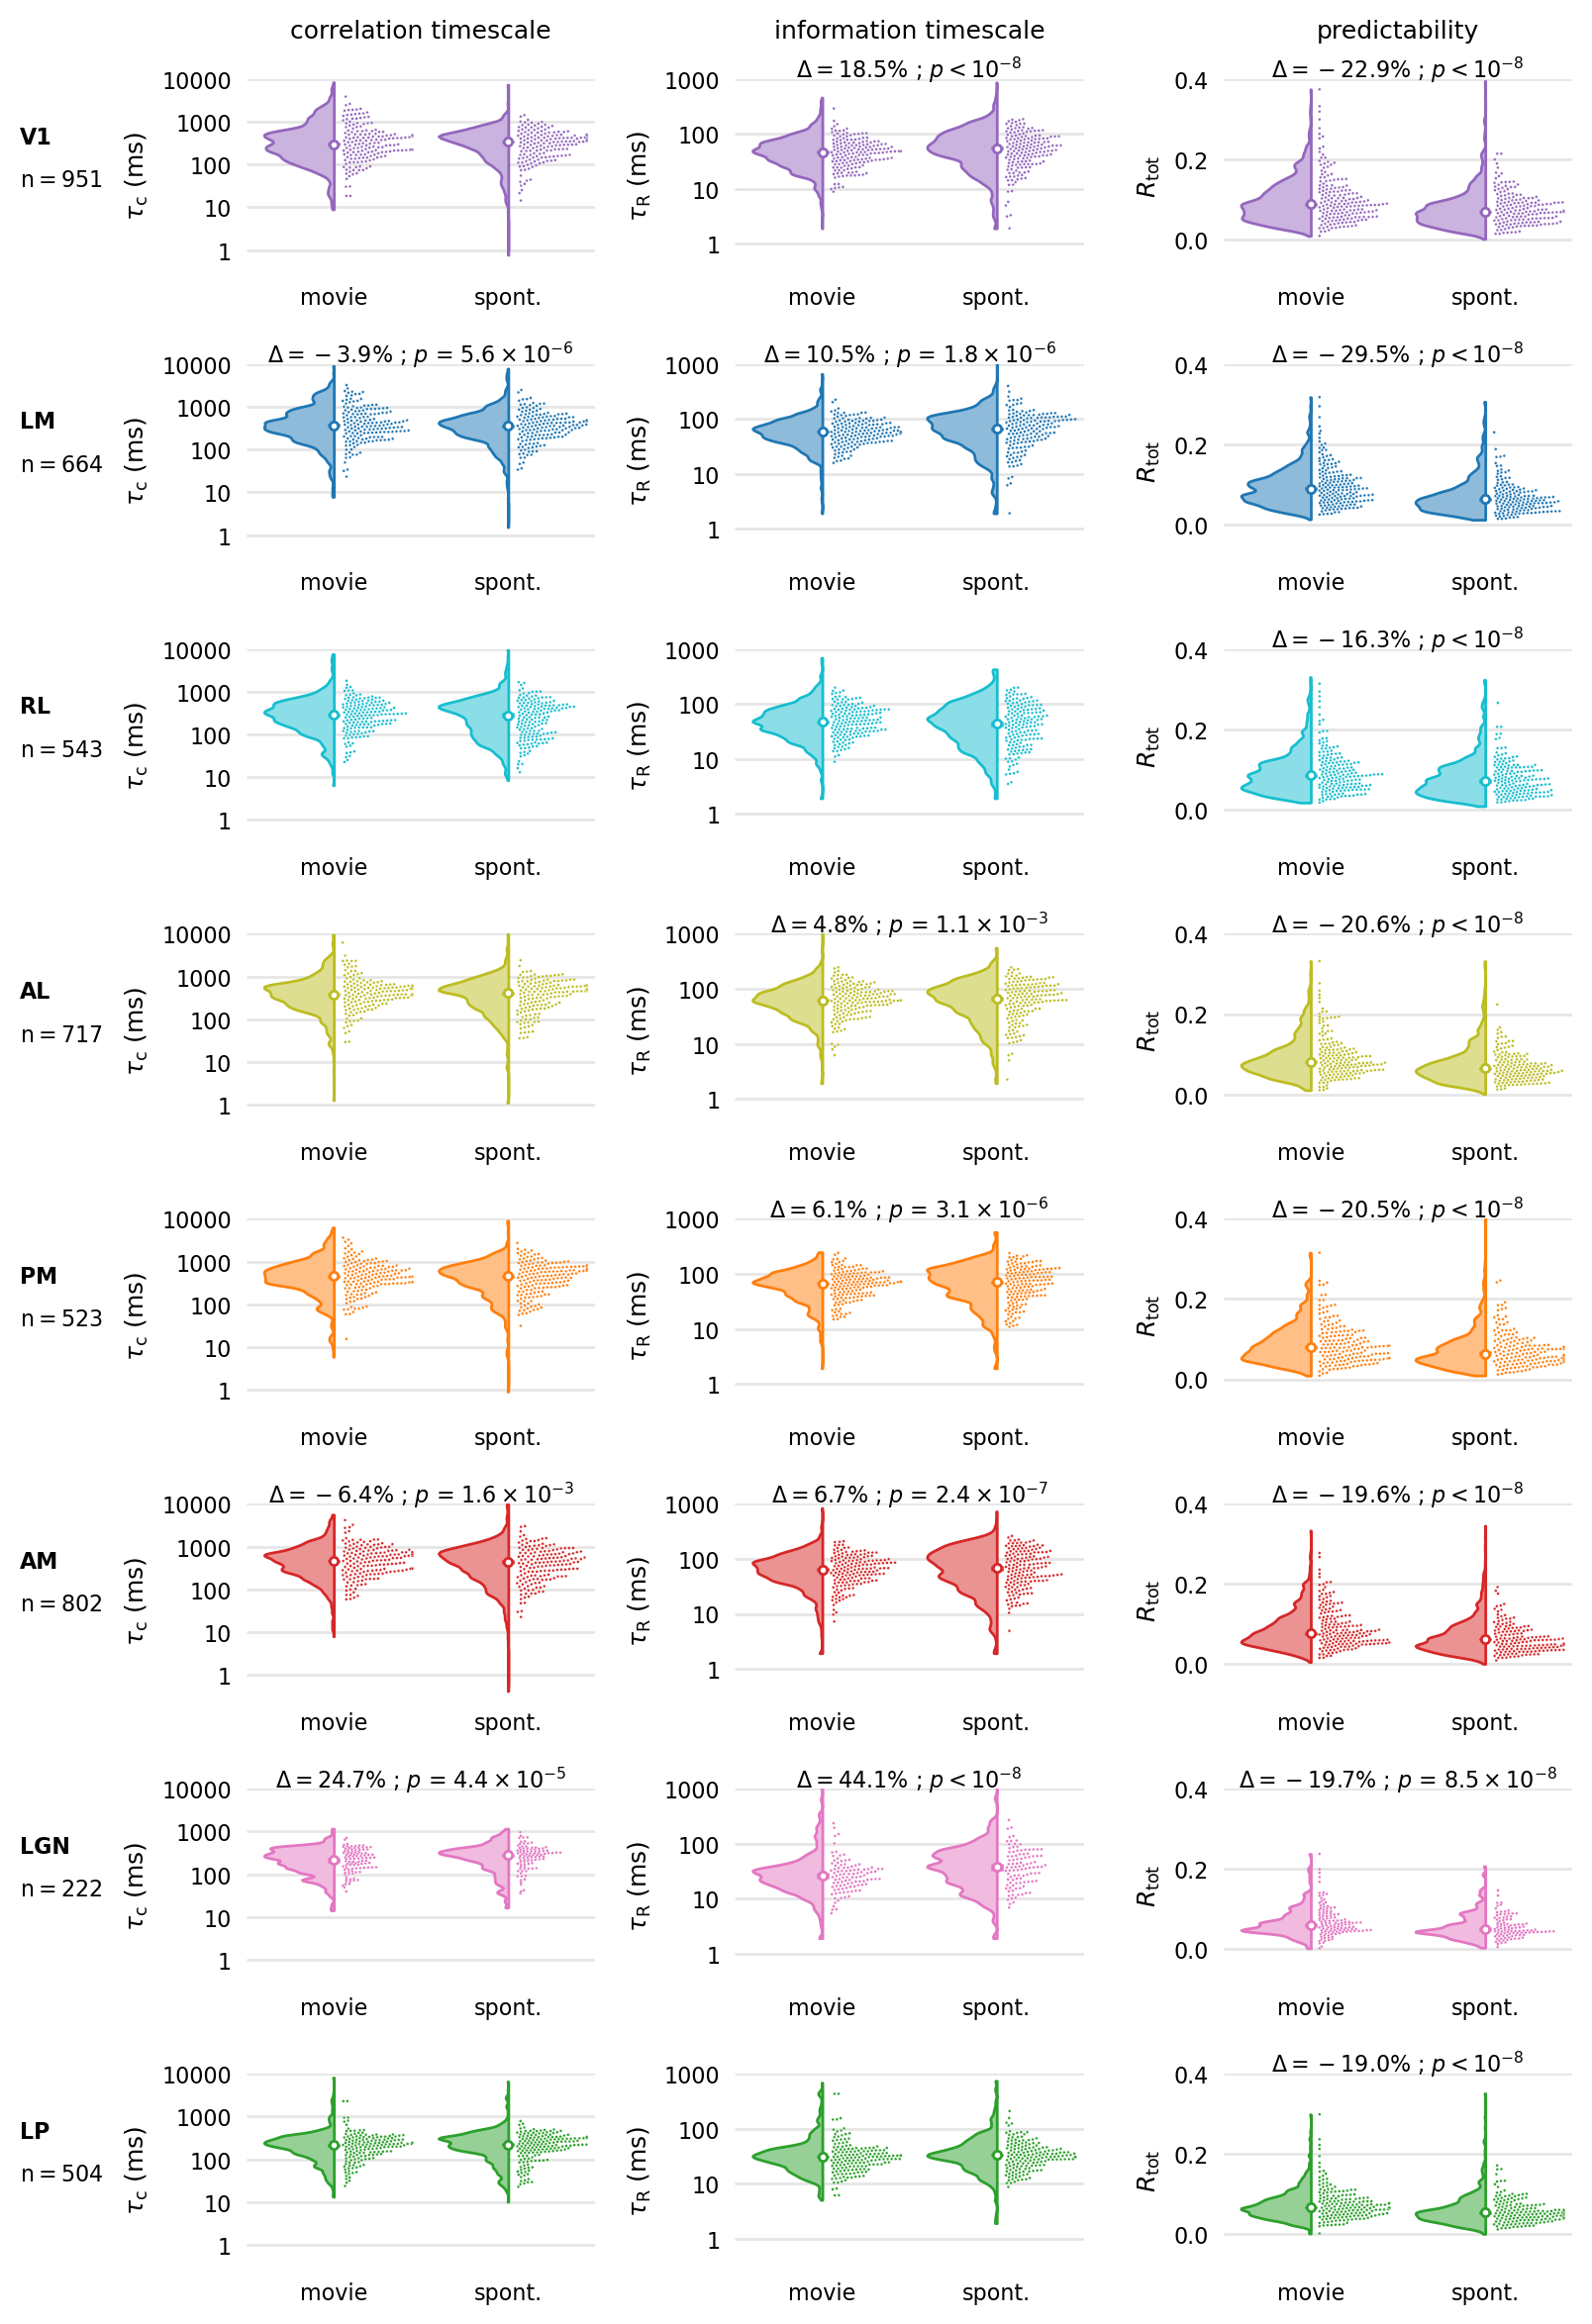

In [60]:
# Violin plots for stimulus conditions for each area

plot_settings = {}
plot_settings["textwidth"] = 5.787402103

color_palette = sns.color_palette().as_hex()
hex_area_colors = [
    color_palette[4],
    color_palette[0],
    color_palette[9],
    color_palette[8],
    color_palette[1],
    color_palette[3],
    color_palette[6],
    color_palette[2],
]

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam", "LGd", "LP"]
area_names = {
    "VISp": "V1",
    "VISl": "LM",
    "VISal": "AL",
    "VISpm": "PM",
    "VISam": "AM",
    "VISrl": "RL",
    "LGd": "LGN",
    "LP": "LP",
}
area_colors = {area: hex_area_colors[i] for i, area in enumerate(areas)}
observables = ["tau_double", "tau_R", "R_tot"]

fig, axes = plt.subplots(8, 3, figsize=(1.3 * plot_settings["textwidth"], 13))
fig.subplots_adjust(left=0.01, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.48)

bonferroni_correction = 1 / (len(axes) * len(observables))

for i, rows in enumerate(axes):
    # this iterates over brain areas
    area = areas[i]
    area_name = area_names[area]
    color = hex_area_colors[i]
    kwargs = {
        "area_name": area_name,
        "x_text": -1.15,
        "bonferroni_correction": bonferroni_correction,
    }

    ax0 = rows[0]
    ax1 = rows[1]
    ax2 = rows[2]

    # Set subtitle
    if i == 0:
        ax0.set_title(
            r"correlation timescale", pad=15
        )  # , usetex = True, fontsize = 16)
        ax1.set_title(
            r"information timescale", pad=15
        )  # , usetex = True, fontsize = 16)
        ax2.set_title(r"predictability", pad=15)  # , usetex = True, fontsize = 16)

    if i == len(axes) - 1:
        plot_xlabel = True

    for ax, obs in zip([ax0, ax1, ax2], observables):
        # this iterates over the three observables
        with mpl.rc_context(
            {"xtick.labelsize": 8, "axes.labelsize": 8, "font.size": 8}
        ):
            ax = ph.panel_stimulus_violins(
                df = meta_df.query("ecephys_structure_acronym == @area"),
                observable = obs,
                ax=ax, #CHECK IN FUNCTION
                logscale=False if obs == "R_tot" else True,
                plot_ylabel=False,
                areawise_plot=True,
                area_name=area_name,
                x_area_name=-1.8,
                bonferroni_correction=bonferroni_correction,
                category = "stimulus",
                num_swarm_points=350,
                seed=44,
                replace = False,
                same_points_per_swarm=True,
                xlabels = ['movie', 'spont.'],
                # specify palette to make sure labels are correct!
                palette={
                        "natural_movie_one_more_repeats" : color,
                        "spontaneous" : color,
                    },
                swarm_spacing = 0.3,
                swarm_kwargs=dict(
                    size=1.0,
                    linewidth=0.10,
                ),
                violin_kwargs=dict(
                    bw=0.13,
                ),
            )
            #
# set_size(ax, w=4.0, h=2.1)
plt.savefig(
    "../img/SI_stimulus_comparison_for_areas.pdf",
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

In [61]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.20.0

scipy: 1.10.1

re        : 2.2.1
dask      : 2024.5.0
logging   : 0.5.1.2
pandas    : 1.5.3
seaborn   : 0.11.2
sys       : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
numpy     : 1.23.5
h5py      : 3.11.0
xarray    : 2023.1.0
matplotlib: 3.8.4

